In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import csv
import json
import sklearn
from google.cloud import bigquery as bq
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.mode.chained_assignment = None
%matplotlib inline

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

In [3]:
query="""
    SELECT
      *
    FROM
      `ual3d-277909.nl.zuid_holland_ml_df` 
"""

df = bq.Client().query(query).to_dataframe()
df.head()

,osm_way_id,bldg_height,area,perimeter,length,building_levels,city,country,postcode,year,count_vertices,compactness,complexity,count_neighbor,state_name
0,255340981,17.75,66.161703,34.578667,13.354728,NaN,None,NL,None,1896.0,6,0.833873,12.124297,523.0,South Holland
1,264846253,10.84,79.653939,38.594353,14.412437,NaN,None,NL,None,1894.0,8,0.819756,12.918793,613.0,South Holland
2,280800819,8.94,52.666702,30.304063,11.161897,NaN,None,NL,None,1850.0,5,0.848930,11.249075,726.0,South Holland
3,275822549,16.07,93.897448,43.861190,16.943170,NaN,None,NL,None,1937.0,7,0.783162,14.090194,679.0,South Holland
4,268949562,12.44,804.458197,138.052077,48.793231,NaN,None,NL,None,1777.0,15,0.728306,25.921915,7.0,South Holland


In [4]:
df.set_index('osm_way_id', inplace=True)

In [5]:
df.shape

(1638666, 14)

In [6]:
df.dtypes

bldg_height        float64
area               float64
perimeter          float64
length             float64
building_levels    float64
city                object
country             object
postcode            object
year               float64
count_vertices       int64
compactness        float64
complexity         float64
count_neighbor     float64
state_name          object
dtype: object

In [7]:

df["city"] = df["city"].astype("category")
df["state_name"] = df["state_name"].astype("category")
df["country"] = df["country"].astype("category")
df["postcode"] = df["postcode"].astype("category")
# df["year"] = df["year"].astype(float).astype("Int64")
# df["count_vertices"] = df["count_vertices"].astype(float).astype("Int64")
# df["count_neighbor"] = df["count_neighbor"].astype(float).astype("Int64")
# df["building_levels"] = df["building_levels"].astype(float).astype("Int64")
df.dtypes

bldg_height         float64
area                float64
perimeter           float64
length              float64
building_levels     float64
city               category
country            category
postcode           category
year                float64
count_vertices        int64
compactness         float64
complexity          float64
count_neighbor      float64
state_name         category
dtype: object

In [8]:
label_col = ["bldg_height"]
num_cols = ["area", "perimeter", "length", "building_levels", "year", "count_vertices", "compactness", "complexity", "count_neighbor"]
# cat_cols = ["city", "postcode"]
cat_cols = [col for col in df.columns if col not in (num_cols + label_col)]


In [9]:
print('count unique city:', len(pd.unique(df['city'])))
print('unique city:', pd.unique(df['city']))

print('\ncount unique postcode:', len(pd.unique(df['postcode'])))
print('unique postcode:', pd.unique(df['postcode']))

print('\ncount unique year:', len(pd.unique(df['year'])))
print('unique year:', pd.unique(df['year']))

count unique city: 102
unique city: [NaN, 's-Gravenhage, Puttershoek, Dordrecht, Noordwijk, ..., Nieuwerbrug aan den Rijn, Zuid-Beijerland, De Lier, Kaag, Ridderkerk]
Length: 102
Categories (101, object): ['s-Gravenhage, Puttershoek, Dordrecht, Noordwijk, ..., Zuid-Beijerland, De Lier, Kaag, Ridderkerk]

count unique postcode: 683
unique postcode: [NaN, 2522BB, 2517AG, 2512HD, 3297LH, ..., 2652MJ, 3274KR, 2583, 4207HW, 2342BB]
Length: 683
Categories (682, object): [2522BB, 2517AG, 2512HD, 3297LH, ..., 3274KR, 2583, 4207HW, 2342BB]

count unique year: 583
unique year: [1896. 1894. 1850. 1937. 1777. 1940. 1912. 1903. 1906. 2019. 1612. 1932.
 1916. 1859. 1922. 1880. 1915. 1918. 1941. 1948. 1949. 1947. 1936. 1914.
 1908. 1924. 1881. 1942. 1909. 1870. 1923. 1917. 1875. 1905. 1893. 1921.
 1898. 1919. 1943. 1707. 1890. 1904. 1913. 1820. 1902. 1907. 1861. 1901.
 1895. 1825. 1899. 1945. 1891. 1650. 1780. 1860. 1750. 1475. 1946. 1883.
 1888. 1885. 1872. 1877. 1856. 1765. 1800. 1869. 1674. 1897. 

In [10]:
df.isna().sum()

bldg_height              0
area                     0
perimeter                0
length                   0
building_levels    1615564
city               1637782
country                  0
postcode           1637821
year                   132
count_vertices           0
compactness              0
complexity               0
count_neighbor         234
state_name               0
dtype: int64

In [11]:

num_df = df[num_cols]

In [12]:
num_df.describe()

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor
count,1.638666e+06,1.638666e+06,1.638666e+06,23102.000000,1.638534e+06,1.638666e+06,1.638666e+06,1.638666e+06,1.638432e+06
mean,1.284413e+02,3.442989e+01,1.248890e+01,1.534716,1.970038e+03,7.308884e+00,8.203220e-01,1.150416e+01,6.271445e+02
std,1.201438e+03,4.307075e+01,1.500313e+01,1.667968,3.692588e+01,5.192885e+00,7.008799e-02,5.160273e+00,3.077715e+02
min,2.650812e-04,8.183244e-02,3.404680e-02,-4.000000,1.131000e+03,4.000000e+00,2.828082e-02,6.413288e-01,1.000000e+00
25%,1.107290e+01,1.383930e+01,5.054998e+00,1.000000,1.957000e+03,5.000000e+00,7.915906e-01,7.573893e+00,4.300000e+02
50%,5.009999e+01,2.977105e+01,1.085595e+01,1.000000,1.976000e+03,5.000000e+00,8.439439e-01,1.113455e+01,6.390000e+02
75%,7.143773e+01,3.887442e+01,1.431944e+01,2.000000,1.993000e+03,8.000000e+00,8.719881e-01,1.333404e+01,8.330000e+02
max,2.562055e+05,3.925806e+03,9.652139e+02,44.000000,2.020000e+03,7.930000e+02,9.999417e-01,2.340868e+02,2.143000e+03


[]

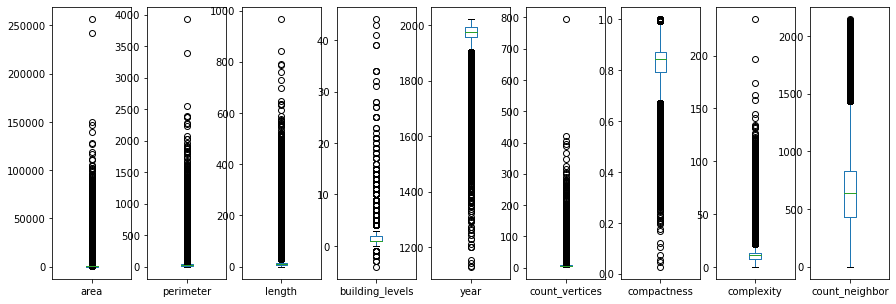

In [13]:
num_df.plot(kind='box', subplots=True, figsize=(15,5))
plt.plot()

In [14]:
df.columns

Index(['bldg_height', 'area', 'perimeter', 'length', 'building_levels', 'city',
       'country', 'postcode', 'year', 'count_vertices', 'compactness',
       'complexity', 'count_neighbor', 'state_name'],
      dtype='object')

In [15]:
# drop country and state_name as they are irrelevant 
df = df.drop(['country', 'state_name'], axis=1)
print(df.columns)

Index(['bldg_height', 'area', 'perimeter', 'length', 'building_levels', 'city',
       'postcode', 'year', 'count_vertices', 'compactness', 'complexity',
       'count_neighbor'],
      dtype='object')


In [16]:
cat_cols = [col for col in df.columns if col not in (num_cols + label_col)]
print(cat_cols)
print(num_cols)

['city', 'postcode']
['area', 'perimeter', 'length', 'building_levels', 'year', 'count_vertices', 'compactness', 'complexity', 'count_neighbor']


In [17]:
cat_df = df[cat_cols]

In [18]:
X = df.drop('bldg_height', axis=1)
y = df['bldg_height']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [19]:
X, y

(                  area   perimeter     length  building_levels city postcode  \
 osm_way_id                                                                     
 255340981    66.161703   34.578667  13.354728              NaN  NaN      NaN   
 264846253    79.653939   38.594353  14.412437              NaN  NaN      NaN   
 280800819    52.666702   30.304063  11.161897              NaN  NaN      NaN   
 275822549    93.897448   43.861190  16.943170              NaN  NaN      NaN   
 268949562   804.458197  138.052077  48.793231              NaN  NaN      NaN   
 ...                ...         ...        ...              ...  ...      ...   
 574580067   107.262698   52.922472  17.938985              NaN  NaN      NaN   
 530584873    96.283272   47.274729  17.107742              NaN  NaN      NaN   
 654049596    64.939874   35.567054  13.238983              NaN  NaN      NaN   
 589028690     6.420915   10.225124   3.648813              NaN  NaN      NaN   
 552466625    41.799551   26

In [20]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean', add_indicator=True)),
    ('scaler', StandardScaler())])


In [21]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', add_indicator=True, fill_value="NA")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [22]:
print(len(cat_cols))
print(len(num_cols))
print(len(df.columns))

2
9
12


In [23]:
preprocessor = ColumnTransformer(transformers=[
        ('num_transformer', num_transformer, num_cols),
        ('cat_transfomer', cat_transformer, cat_cols)])

In [24]:
# ('imputer', KNNImputer(n_neighbors=50, weights='uniform'))
# ,('kbest', SelectKBest(f_regression, k=5))
# ,('kbest', SelectKBest(f_regression, k=50))

In [25]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [26]:
# print(sorted(sklearn.metrics.SCORERS.keys()) )

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'v_measure_score']


In [29]:
regressors = []
# regressors.append(('LR', LinearRegression()))
# regressors.append(('DT', DecisionTreeRegressor()))
# regressors.append(('DT', DecisionTreeRegressor(max_depth=30, random_state=42)))
# regressors.append(('KNN', KNeighborsRegressor()))
# regressors.append(('KNN', KNeighborsRegressor(n_neighborsint=30, weights="distance")))
regressors.append(('RF', RandomForestRegressor()))
# regressors.append(('RF', RandomForestRegressor(n_estimators=100, max_depth=10)))
regressors.append(('AB', AdaBoostRegressor()))
regressors.append(('B', BaggingRegressor()))
regressors.append(('GB', GradientBoostingRegressor()))
reg_scores = {}

In [30]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.3, random_state=42)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error', error_score='raise', n_jobs=-1)
    reg_scores[name] = scores
    msg = "%s: avg: %f (std: %f, max: %f, min: %f)" % (name, scores.mean(), scores.std(), scores.max(), scores.min())
    print(msg)

KeyboardInterrupt: 

In [ ]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(reg_scores.values())
ax.set_xticklabels(reg_scores.keys())
plt.plot()

In [ ]:
regressors = []
regressors.append(('LR', LinearRegression()))
regressors.append(('DT', DecisionTreeRegressor()))
# regressors.append(('DT', DecisionTreeRegressor(max_depth=30, random_state=42)))
regressors.append(('KNN', KNeighborsRegressor()))
# regressors.append(('KNN', KNeighborsRegressor(n_neighborsint=30, weights="distance")))
regressors.append(('RF', RandomForestRegressor()))
# regressors.append(('RF', RandomForestRegressor(n_estimators=100, max_depth=10)))
regressors.append(('AB', AdaBoostRegressor()))
regressors.append(('B', BaggingRegressor()))
regressors.append(('GB', GradientBoostingRegressor()))
reg_scores = {}

In [ ]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.3, random_state=42)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', error_score='raise', n_jobs=-1)
    reg_scores[name] = scores
    msg = "%s: avg: %f (std: %f, max: %f, min: %f)" % (name, scores.mean(), scores.std(), scores.max(), scores.min())
    print(msg)

In [ ]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(reg_scores.values())
ax.set_xticklabels(reg_scores.keys())
plt.plot()

In [ ]:
regressors = []
regressors.append(('LR', LinearRegression()))
regressors.append(('DT', DecisionTreeRegressor()))
# regressors.append(('DT', DecisionTreeRegressor(max_depth=30, random_state=42)))
regressors.append(('KNN', KNeighborsRegressor()))
# regressors.append(('KNN', KNeighborsRegressor(n_neighborsint=30, weights="distance")))
regressors.append(('RF', RandomForestRegressor()))
# regressors.append(('RF', RandomForestRegressor(n_estimators=100, max_depth=10)))
regressors.append(('AB', AdaBoostRegressor()))
regressors.append(('B', BaggingRegressor()))
regressors.append(('GB', GradientBoostingRegressor()))
reg_scores = {}

In [ ]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.3, random_state=42)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='r2', error_score='raise', n_jobs=-1)
    reg_scores[name] = scores
    msg = "%s: avg: %f (std: %f, max: %f, min: %f)" % (name, scores.mean(), scores.std(), scores.max(), scores.min())
    print(msg)

In [ ]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(reg_scores.values())
ax.set_xticklabels(reg_scores.keys())
plt.plot()

In [ ]:
cv = ShuffleSplit(n_splits=5, test_size=.3, random_state=42)
gs_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', RandomForestRegressor())])

In [ ]:
grid_params = {
    'preprocessor__year_transformer__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'preprocessor__bldg_lvls_transformer__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'regressor__max_depth': [3, 5, 10, 25, 30, 50],
    'regressor__n_estimators': [10, 100, 500, 1000],
    'regressor__max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(gs_pipeline, grid_params, cv=cv, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

In [ ]:
best_params = grid_search.best_params_
best_params

In [ ]:
best_estimator = grid_search.best_estimator_
print(best_estimator)


In [ ]:
best_score = grid_search.best_score_
best_score

In [ ]:
cv = ShuffleSplit(n_splits=5, test_size=.3, random_state=42)
gs_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', GradientBoostingRegressor())])

In [ ]:
grid_params = {
    'preprocessor__year_transformer__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'preprocessor__bldg_lvls_transformer__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'regressor__loss': ['ls', 'lad', 'huber', 'quantile'],
    'regressor__learning_rate': [0.05, 0.01, 0.1, 0.5],
    'regressor__criterion': ['friedman_mse', 'mse'],
    'regressor__max_depth': [3, 5, 10, 25, 30, 50],
    'regressor__n_estimators': [10, 100, 500, 1000],
    'regressor__max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(gs_pipeline, grid_params, cv=cv, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)